# DBSCAN — Non-spherical clusters and noise handling
This notebook demonstrates DBSCAN on a moon-shaped dataset, including injected outliers and missing values, preprocessing, model fitting, evaluation, and an evolution diagram showing how cluster assignments change as eps varies.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

sns.set(style="whitegrid")

In [2]:
# Create dataset (moons) with some aberrant data and missing values
rng = np.random.RandomState(42)
X, y = make_moons(n_samples=600, noise=0.05, random_state=42)
# add distant outliers (3%)
n_out = int(0.03 * X.shape[0])
out_idx = rng.choice(X.shape[0], n_out, replace=False)
X[out_idx] += rng.normal(0, 6.0, size=(n_out, X.shape[1]))
# inject missing values (~1% of entries)
n_nan = max(1, int(0.01 * X.size))
rows = rng.randint(0, X.shape[0], n_nan)
cols = rng.randint(0, X.shape[1], n_nan)
X[rows, cols] = np.nan

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Shapes -- train/test:", X_train.shape, X_test.shape)
print("NaNs -- train/test:", np.isnan(X_train).sum(), np.isnan(X_test).sum())

Shapes -- train/test: (420, 2) (180, 2)
NaNs -- train/test: 9 3


In [3]:
# Preprocessing: impute then scale (RobustScaler is robust to outliers)
imputer = SimpleImputer(strategy='mean')
Xtr_imp = imputer.fit_transform(X_train)
Xte_imp = imputer.transform(X_test)

scaler = RobustScaler()
Xtr = scaler.fit_transform(Xtr_imp)
Xte = scaler.transform(Xte_imp)

In [4]:
# Train DBSCAN and predict cluster labels (fit_predict on each split)
db = DBSCAN(eps=0.2, min_samples=5)
labels_tr = db.fit_predict(Xtr)
labels_te = db.fit_predict(Xte)

# Helpers
def cluster_count(labels):
    return len([l for l in set(labels) if l != -1])

def safe_silhouette(X, labels):
    try:
        if len(set(labels)) > 1 and not (set(labels) == {-1}):
            return silhouette_score(X, labels)
    except Exception:
        pass
    return np.nan

# Metrics
metrics = {
    'Clusters_train': cluster_count(labels_tr),
    'Noise_train': list(labels_tr).count(-1),
    'ARI_train': adjusted_rand_score(y_train, labels_tr),
    'NMI_train': normalized_mutual_info_score(y_train, labels_tr),
    'Silhouette_train': safe_silhouette(Xtr, labels_tr),
    'Clusters_test': cluster_count(labels_te),
    'Noise_test': list(labels_te).count(-1),
    'ARI_test': adjusted_rand_score(y_test, labels_te),
    'NMI_test': normalized_mutual_info_score(y_test, labels_te),
    'Silhouette_test': safe_silhouette(Xte, labels_te),
}

for k, v in metrics.items():
    print(f"{k}: {v}")

Clusters_train: 2
Noise_train: 13
ARI_train: 0.929686234737089
NMI_train: 0.8739860609081274
Silhouette_train: 0.3088878392353155
Clusters_test: 3
Noise_test: 5
ARI_test: 0.7133775660694947
NMI_test: 0.7390844708349823
Silhouette_test: 0.36422831874699496


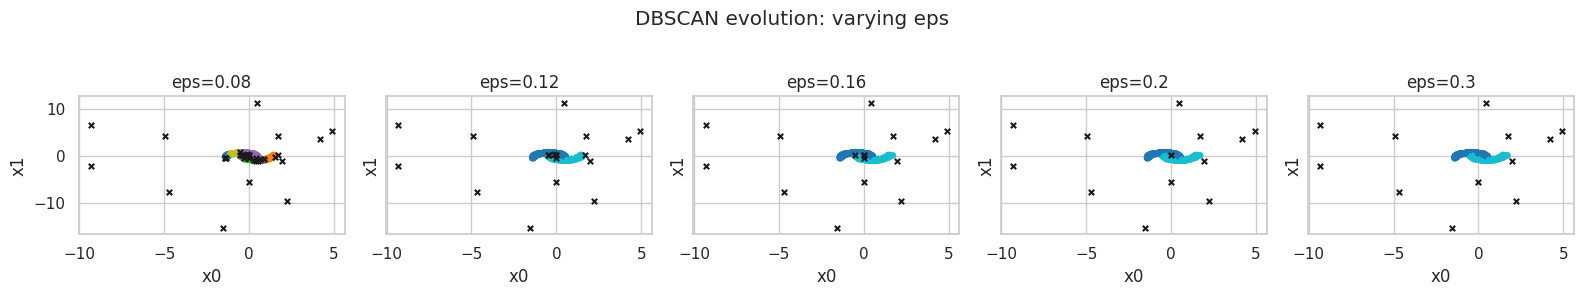

In [5]:
# Evolution: show DBSCAN behavior as eps varies
eps_list = [0.08, 0.12, 0.16, 0.2, 0.3]
palette = sns.color_palette('tab10', n_colors=len(eps_list))

fig, axes = plt.subplots(1, len(eps_list), figsize=(16, 3), sharex=True, sharey=True)
for ax, eps, pal in zip(axes, eps_list, palette):
    lbls = DBSCAN(eps=eps, min_samples=5).fit_predict(Xtr)
    # plot: noise in black, clusters colored
    pts_noise = (lbls == -1)
    ax.scatter(Xtr[~pts_noise, 0], Xtr[~pts_noise, 1], c=lbls[~pts_noise], cmap='tab10', s=15)
    if pts_noise.any():
        ax.scatter(Xtr[pts_noise, 0], Xtr[pts_noise, 1], c='k', s=15, marker='x', label='noise')
    ax.set_title(f'eps={eps}')
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
plt.suptitle('DBSCAN evolution: varying eps')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

DBSCAN — Clear explanation with keywords

DBSCAN groups points into clusters based on how densely packed they are.

Key terms and short explanations:

- **Density** — how many points are near each other; DBSCAN finds regions with high density and calls them clusters.
- **eps** — the radius used to look for nearby points; larger eps means points further apart can be in the same cluster.
- **min_samples** — the minimum number of nearby points required to consider a region a cluster (helps ignore small noisy groups).
- **Noise / Outlier** — points that do not belong to any dense region are labeled as noise — DBSCAN explicitly marks them.

When to use DBSCAN: use it when you expect clusters of irregular shapes and when you want the algorithm to detect outliers automatically. Preprocessing (imputation and **RobustScaler**) helps make distance calculations more reliable in presence of outliers.

Conclusion / Observations

- DBSCAN successfully separated the moon-shaped clusters and labeled isolated points as **noise** (outliers), showing it handles **non‑spherical clusters** well.
- Results are sensitive to **eps** (neighborhood radius) and **min_samples**; too small eps yields many noise points, too large eps can merge distinct clusters.
- Preprocessing (imputation + **RobustScaler**) reduced the influence of aberrant values on distance calculations.

Next steps: use a k‑distance plot to choose eps, experiment with different min_samples, and compare DBSCAN results with other clustering methods when cluster shapes or densities vary.